In [1]:
import pathlib
import re
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers as L                   
from keras.applications import EfficientNetB0      
from keras.applications.efficientnet import preprocess_input

2025-06-22 08:30:21.313677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 08:30:21.321033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-22 08:30:21.330054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-22 08:30:21.332654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-22 08:30:21.339179: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
import gc

tf.keras.backend.clear_session()   # drop everything from the prior model
gc.collect()                       # free Python-side objects as well

# optional but recommended if you allocated a lot previously
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Configuration Constants
DATA_ROOT   = pathlib.Path("../Datasets")          # <- adjust if needed
IMG_SIZE    = (224, 224)                        # images are 224×224×3
BATCH_SIZE  = 32
EPOCHS      = 40
SEED        = 42

# --- 1. Collect file paths ----------------------------------------------------
train_files, train_labels = [], []
test_files , test_labels  = [], []

class_names = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
class_to_idx = {c: i for i, c in enumerate(class_names)}

pattern = re.compile(r"(\d+)\.(jpg|jpeg|png)$", re.IGNORECASE)

for cls in class_names:
    for fp in (DATA_ROOT / cls).iterdir():
        m = pattern.search(fp.name)
        if not m:                    # skip non-image files
            continue
        idx = int(m.group(1))
        target = test_files if idx % 5 == 0 else train_files
        labels = test_labels if idx % 5 == 0 else train_labels
        target.append(str(fp))
        labels.append(class_to_idx[cls])

print(f"Train images: {len(train_files)}, Test images: {len(test_files)}")

Train images: 692, Test images: 170


In [4]:
# --- 2. Build tf.data datasets ------------------------------------------------
def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(f, y):
        img = tf.io.read_file(f)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = preprocess_input(img)            # MobileNetV2 preprocessing
        return img, tf.one_hot(y, len(class_names))

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        aug = tf.keras.Sequential([
            L.RandomFlip("horizontal"),
            L.RandomRotation(0.05),
            L.RandomZoom(0.1)
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_files, train_labels, training=True)
test_ds  = make_ds(test_files , test_labels , training=False)

I0000 00:00:1750552222.610348   12832 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750552222.647196   12832 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750552222.652588   12832 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750552222.657194   12832 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
# --- 3. Build & compile the model --------------------------------------------
base = EfficientNetB0(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet")

base.trainable = False                       # first train only the head

model = tf.keras.Sequential([
    base,
    L.GlobalAveragePooling2D(),
    L.Dropout(0.25),
    L.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [6]:
# --- 4. Train (head only) -----------------------------------------------------
hist = model.fit(train_ds,
                 epochs=EPOCHS,
                 validation_data=test_ds,
                 callbacks=[
                     tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
                 ])

Epoch 1/40


I0000 00:00:1750552228.227273   12990 service.cc:146] XLA service 0x7de4c014c080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750552228.227293   12990 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-06-22 08:30:28.352817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-22 08:30:28.910292: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90501


 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2398 - loss: 1.6194

I0000 00:00:1750552235.352548   12990 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3706 - loss: 1.4606

2025-06-22 08:30:44.106324: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 100 bytes spill stores, 100 bytes spill loads

2025-06-22 08:30:44.158868: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 340 bytes spill stores, 340 bytes spill loads

2025-06-22 08:30:46.780275: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2060', 60 bytes spill stores, 60 bytes spill loads



22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 722ms/step - accuracy: 0.3760 - loss: 1.4529 - val_accuracy: 0.6118 - val_loss: 0.9562
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7012 - loss: 0.8768 - val_accuracy: 0.7941 - val_loss: 0.6927
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8022 - loss: 0.6462 - val_accuracy: 0.8471 - val_loss: 0.5620
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8374 - loss: 0.5523 - val_accuracy: 0.8765 - val_loss: 0.4883
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8626 - loss: 0.4878 - val_accuracy: 0.9059 - val_loss: 0.4249
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8741 - loss: 0.4063 - val_accuracy: 0.9118 - val_loss: 0.3903
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9025 - loss: 0.3867 - val_accuracy: 0.9059 - val_loss: 0.3581
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9220 - loss: 0.3274 - val_accuracy: 0.9235 - val_loss: 

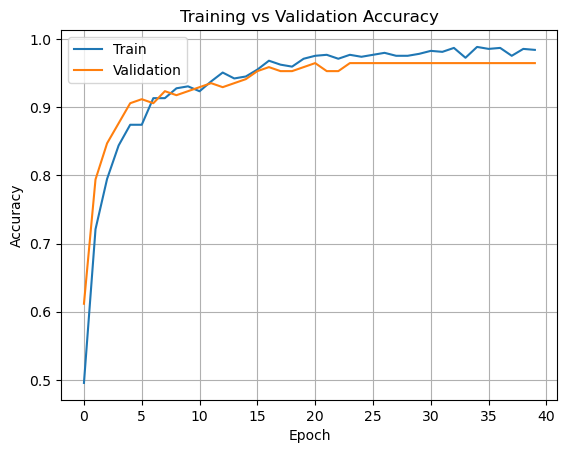

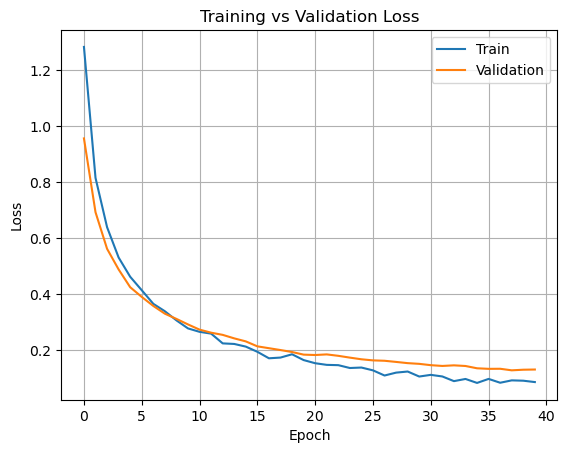

In [7]:
# 1) Accuracy history ----------------------------------------------------------
acc      = hist.history["accuracy"]
val_acc  = hist.history["val_accuracy"]

plt.figure()                    # one distinct plot
plt.plot(acc,     label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 2) Loss history --------------------------------------------------------------
loss     = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.figure()                    # second distinct plot
plt.plot(loss,     label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [8]:
# --- 5. Optional fine-tuning ---------------------------------------------------
base.trainable = True
for layer in base.layers[:-20]:              # unfreeze last ~20 layers only
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
hist = model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=test_ds,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=10,
                                               restore_best_weights=True)
          ])

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step - accuracy: 0.9264 - loss: 0.2893 - val_accuracy: 0.9647 - val_loss: 0.1278
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9749 - loss: 0.1340 - val_accuracy: 0.9706 - val_loss: 0.1206
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9798 - loss: 0.0998 - val_accuracy: 0.9647 - val_loss: 0.1059
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9898 - loss: 0.0779 - val_accuracy: 0.9706 - val_loss: 0.1027
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9893 - loss: 0.0578 - val_accuracy: 0.9706 - val_loss: 0.0957
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9894 - loss: 0.0555 - val_accuracy: 0.9706 - val_loss: 0.0814
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9989 - loss: 0.0371 - val_accuracy: 0.9765 - val_loss: 0.0620
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9946 - loss: 0.0347 - val_accuracy: 0.9765 -

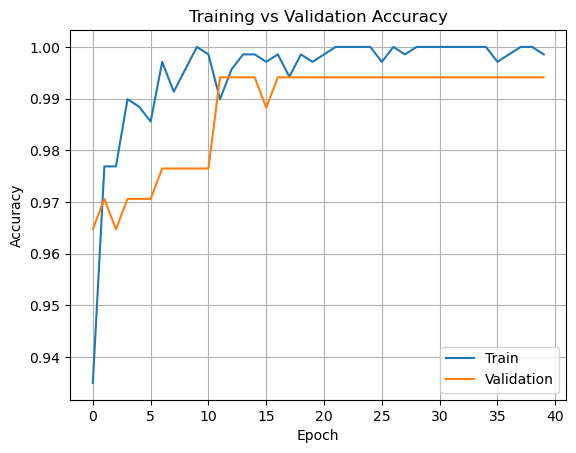

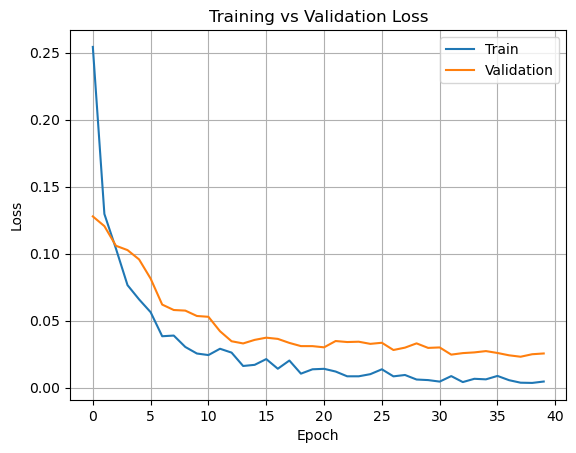

In [9]:
# 1) Accuracy history ----------------------------------------------------------
acc      = hist.history["accuracy"]
val_acc  = hist.history["val_accuracy"]

plt.figure()                    # one distinct plot
plt.plot(acc,     label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 2) Loss history --------------------------------------------------------------
loss     = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.figure()                    # second distinct plot
plt.plot(loss,     label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [10]:
# --- 6. Inspect mis-classifications ------------------------------------------
y_true, y_pred, file_paths = [], [], []

for (x, y), paths in zip(test_ds.unbatch(), np.array(test_files)):
    logits = model(tf.expand_dims(x, 0), training=False)
    y_true.append(tf.argmax(y).numpy())
    y_pred.append(tf.argmax(logits, axis=1).numpy()[0])
    file_paths.append(paths)

mis_idx = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print("\nMis-classified samples (truth -> pred):")
for i in mis_idx:
    print(f"{file_paths[i]} : {class_names[y_true[i]]} → {class_names[y_pred[i]]}")

W0000 00:00:1750552345.015061   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.027664   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.028223   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.029047   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.030270   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.030798   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.031330   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.031863   12832 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750552345.032402   12832 gp


Mis-classified samples (truth -> pred):
../Datasets/Healthy/45.jpeg : Healthy → Brown_Spot


2025-06-22 08:32:39.335347: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
